In [1]:
import time
import sys
sys.path.append("../../")
import os
import papermill as pm
from tempfile import TemporaryDirectory
import xlearn as xl
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib notebook
from matplotlib import pyplot as plt

from reco_utils.common.constants import SEED
from reco_utils.common.timer import Timer
from reco_utils.recommender.deeprec.deeprec_utils import (
    download_deeprec_resources, prepare_hparams
)
from reco_utils.recommender.deeprec.models.xDeepFM import XDeepFMModel
from reco_utils.recommender.deeprec.IO.iterator import FFMTextIterator
from reco_utils.tuning.parameter_sweep import generate_param_grid
from reco_utils.dataset.pandas_df_utils import LibffmConverter

print("System version: {}".format(sys.version))
print("Xlearn version: {}".format(xl.__version__))

System version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Xlearn version: 0.4.4


In [28]:
df_feature_original = pd.DataFrame({
    'rating': [1, 0, 0, 1, 1,1],
    'field1': ['sunshine', 'zeropad', 'nonsense', 'physco', 'datadie','pizza'],
    'field2': [3, 4, 5, 6, 7,6],
    'field3': [1.0, 2.0, 3.0, 4.0, 5.0,6.0],
    'field4': ['jaki', 'monkey', 'mike', 'patta', 'sivakasi','karur']
})

converter = LibffmConverter().fit(df_feature_original, col_rating='rating')
df_out = converter.transform(df_feature_original)
df_out

,rating,field1,field2,field3,field4
0,1,1:1:1,2:7:3,3:8:1.0,4:9:1
1,0,1:2:1,2:7:4,3:8:2.0,4:10:1
2,0,1:3:1,2:7:5,3:8:3.0,4:11:1
3,1,1:4:1,2:7:6,3:8:4.0,4:12:1
4,1,1:5:1,2:7:7,3:8:5.0,4:13:1
5,1,1:6:1,2:7:6,3:8:6.0,4:14:1


In [29]:
print('There are in total {0} fields and {1} features.'.format(converter.field_count, converter.feature_count))

There are in total 4 fields and 14 features.


In [30]:
# Parameters
YAML_FILE_NAME = "xDeepFM.yaml"
TRAIN_FILE_NAME = "cretio_tiny_train"
VALID_FILE_NAME = "cretio_tiny_valid"
TEST_FILE_NAME = "cretio_tiny_test"
MODEL_FILE_NAME = "model.out"
OUTPUT_FILE_NAME = "output.txt"

LEARNING_RATE = 0.2
LAMBDA = 0.002
# The metrics for binary classification options are "acc", "prec", "f1" and "auc"
# for regression, options are "rmse", "mae", "mape"
METRIC = "auc" 
EPOCH = 10
OPT_METHOD = "sgd" # options are "sgd", "adagrad" and "ftrl"

In [31]:
tmpdir = TemporaryDirectory()

data_path = tmpdir.name
yaml_file = os.path.join(data_path, YAML_FILE_NAME)
train_file = os.path.join(data_path, TRAIN_FILE_NAME)
valid_file = os.path.join(data_path, VALID_FILE_NAME)
test_file = os.path.join(data_path, TEST_FILE_NAME)
model_file = os.path.join(data_path, MODEL_FILE_NAME)
output_file = os.path.join(data_path, OUTPUT_FILE_NAME)

if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.blob.core.windows.net/deeprec/', data_path, 'xdeepfmresources.zip')

100%|████████████████████████████████████████████████████████████████████████████| 10.3k/10.3k [00:02<00:00, 4.51kKB/s]


In [32]:
print(train_file)

C:\Users\nancy\AppData\Local\Temp\tmpbvxcrq4m\cretio_tiny_train


In [37]:
# Training task
ffm_model = xl.create_ffm()        # Use field-aware factorization machine (ffm)
ffm_model.setTrain(train_file)     # Set the path of training dataset
ffm_model.setValidate(valid_file)  # Set the path of validation dataset

# Parameters:
#  0. task: binary classification
#  1. learning rate: 0.2
#  2. regular lambda: 0.002
#  3. evaluation metric: auc
#  4. number of epochs: 10
#  5. optimization method: sgd
param = {"task":"binary", 
         "lr": LEARNING_RATE, 
         "lambda": LAMBDA, 
         "metric": METRIC,
         "epoch": EPOCH,
         "opt": OPT_METHOD
        }

# Start to train
# The trained model will be stored in model.out
with Timer() as time_train:
    ffm_model.fit(param, model_file)

# Prediction task
ffm_model.setTest(test_file)  # Set the path of test dataset
ffm_model.setSigmoid()        # Convert output to 0-1

# Start to predict
# The output result will be stored in output.txt
with Timer() as time_predict:
    ffm_model.predict(model_file, output_file)

In [38]:
with open(output_file) as f:
    predictions = f.readlines()

with open(test_file) as f:
    truths = f.readlines()

truths = np.array([float(truth.split(' ')[0]) for truth in truths])
predictions = np.array([float(prediction.strip('')) for prediction in predictions])

auc_score = roc_auc_score(truths, predictions)


In [39]:
print(truths.shape)
print(predictions.shape)

(13572,)
(13572,)


In [41]:
auc_score

0.7483524524892602

In [10]:
!pip install papermill[all]

In [11]:
print('Training takes {0:.2f}s and predicting takes {1:.2f}s.'.format(time_train.interval, time_predict.interval))

Training takes 37.12s and predicting takes 1.70s.


In [12]:
param_dict = {
    "lr": [0.0001, 0.001, 0.01],
    "lambda": [0.001, 0.01, 0.1]
}

param_grid = generate_param_grid(param_dict)

In [13]:
auc_scores = []

with Timer() as time_tune:
    for param in param_grid:
        ffm_model = xl.create_ffm()       
        ffm_model.setTrain(train_file)     
        ffm_model.setValidate(valid_file)
        ffm_model.fit(param, model_file)

        ffm_model.setTest(test_file)  
        ffm_model.setSigmoid()        
        ffm_model.predict(model_file, output_file)

        with open(output_file) as f:
            predictions = f.readlines()

        with open(test_file) as f:
            truths = f.readlines()

        truths = np.array([float(truth.split(' ')[0]) for truth in truths])
        predictions = np.array([float(prediction.strip('')) for prediction in predictions])

        auc_scores.append(roc_auc_score(truths, predictions))

In [19]:
print('Tuning by grid search takes {0:.2} min'.format(time_tune.interval / 60))

Tuning by grid search takes 8.0 min


In [20]:
auc_scores = [float('%.4f' % x) for x in auc_scores]
auc_scores_array = np.reshape(auc_scores, (len(param_dict["lr"]), len(param_dict["lambda"]))) 

auc_df = pd.DataFrame(
    data=auc_scores_array, 
    index=pd.Index(param_dict["lr"], name="LR"), 
    columns=pd.Index(param_dict["lambda"], name="Lambda")
)
auc_df

Lambda,0.001,0.010,0.100
LR,,,
0.0001,0.5528,0.6135,0.7216
0.0010,0.5502,0.6121,0.7248
0.0100,0.5460,0.6168,0.7241


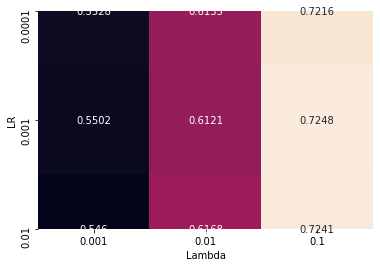

In [21]:
fig, ax = plt.subplots()
sns.heatmap(auc_df, cbar=False, annot=True, fmt=".4g")